In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import zoom


In [ ]:


def load_image_grayscale(path, upsample=1):
    img = Image.open(path).convert('L')  # grayscale
    if upsample != 1:
        new_size = (img.width * upsample, img.height * upsample)
        img = img.resize(new_size, Image.BILINEAR)
    return np.array(img).astype(np.float64)



def illuminate(object, x, y, object_x, object_y, illumination_distance, wave_number):
    """
    Illuminates the object with an LED at a distance x and y
    """
    wave_vector_denominator = np.sqrt(x**2 + y**2 + illumination_distance**2)
    kx = wave_number*x / wave_vector_denominator
    ky = wave_number*y / wave_vector_denominator

    illumination_matrix = object_x*kx + object_y*ky
    illuminated_object = 10*object*np.exp(1j*illumination_matrix)
    return illuminated_object


def imageit(illuminated_object, initial_px, sampled_px, pupil_radius):
    """
    Image the illuminated object and through the imaged image

    """
    ft = np.fft.fftshift(np.fft.fft2(illuminated_object))
    lpf_mask = pupil(0,0, 2*pupil_radius, ft.shape[0], ft.shape[1])
    lpf_ft = np.zeros_like(ft, dtype=complex)
    lpf_ft[lpf_mask] = ft[lpf_mask]
    lpf_image = np.fft.ifft2(np.fft.ifftshift(lpf_ft))

    scale = initial_px / sampled_px
    imaged_image = zoom(np.real(lpf_image), 1/scale)
    return imaged_image

def pupil(ccx, ccy, r, ix, iy):
    """
    Generate a circular mask centered at (ccx, ccy) with radius r
    for an array of size (ix, iy).
    """
    
    cx = ix / 2 + ccx
    cy = iy / 2 + ccy

   
    x = np.arange(iy) - (cy - 1)
    y = np.arange(ix) - (cx - 1)
    xx, yy = np.meshgrid(x, y)

    
    mask = (xx**2 + yy**2) <= r**2
    return mask

def generate_object(intensity_image, phase_image):
    phase_image = (np.pi / 256.0) * phase_image
    phase_image = np.zeros_like(phase_image)  
    return intensity_image * np.exp(1j * phase_image)



def simulate_illumination(intensity_image, phase_image, illumination_layers,
                          LED_spacing, object_x, object_y, illumination_distance,
                          wave_number, initial_px, sampled_px, pupil_radius):
    obj = generate_object(intensity_image, phase_image)
    N = 2 * illumination_layers - 1
    imaged_images = []

    for a in range(N):
        for b in range(N):
            x = (a - illumination_layers + 1) * LED_spacing
            y = (b - illumination_layers + 1) * LED_spacing

            illuminated = illuminate(obj, x, y, object_x, object_y, illumination_distance, wave_number)
            imaged = imageit(illuminated, initial_px, sampled_px, pupil_radius)
            imaged_power = np.abs(imaged) ** 2
            imaged_images.append(imaged_power)
    return np.stack(imaged_images, axis=0)




In [5]:

# Set image paths
cameraman_path = r"C:\Users\Irene\Documents\AA UNI\02_Master\02_Semester\Innovation methods in photonics\Cameraman.png"
orthophoto_path = r"C:\Users\Irene\Documents\AA UNI\02_Master\02_Semester\Innovation methods in photonics\westconcordimage.gif"

# Parameters
initial_px = 0.275  # microns
upsample = 5

# Load and upsample intensity image (grayscale)
intensity_image = load_image_grayscale(cameraman_path, upsample)

# Load, crop, upsample phase image (grayscale)
phase_image_full = load_image_grayscale(orthophoto_path, 1)
phase_crop = phase_image_full[:256, :256]
phase_image_resized = Image.fromarray(phase_crop).resize(
    (intensity_image.shape[1], intensity_image.shape[0]), Image.BILINEAR)
phase_image = np.array(phase_image_resized).astype(np.float64)

# Coordinate grid
object_length = initial_px * intensity_image.shape[0]
step = initial_px
axis = np.arange(-object_length / 2, object_length / 2, step)
object_x, object_y = np.meshgrid(axis, axis)

# Illumination parameters
wavelength = 0.632
wave_number = 2 * np.pi / wavelength
LED_spacing = 4000
illumination_distance = 80000
illumination_layers = 3

# Imaging system
sampled_px = 5.5
NA = 0.08
deltaF = 1 / (2 * intensity_image.shape[0] * (initial_px / upsample))
pupil_radius = round((2 * np.pi * NA / wavelength) / deltaF)

# Simulate imaging
imaged_images = simulate_illumination(
    intensity_image, phase_image,
    illumination_layers, LED_spacing,
    object_x[0], object_y[:, 0],  # 1D arrays
    illumination_distance, wave_number,
    initial_px * upsample, sampled_px,
    pupil_radius
)

C:\Users\Irene\AppData\Local\Temp\ipykernel_3476\2628226877.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


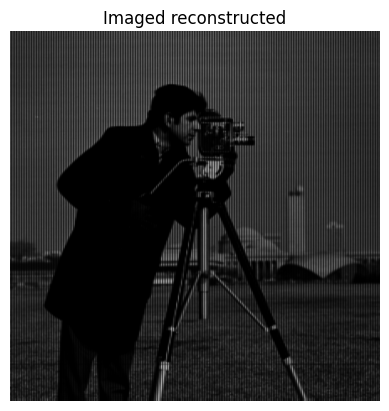

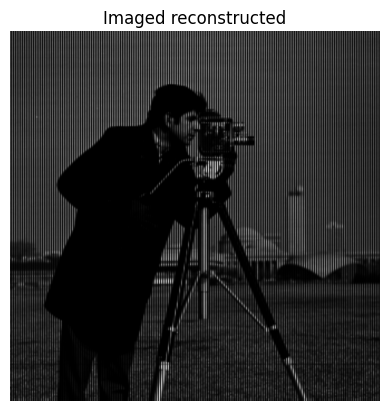

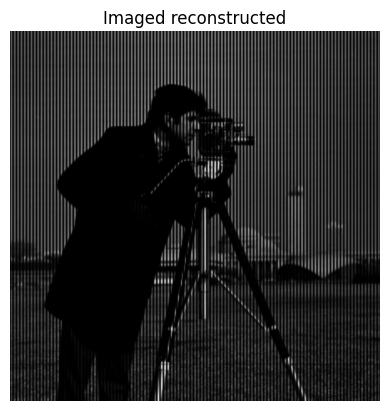

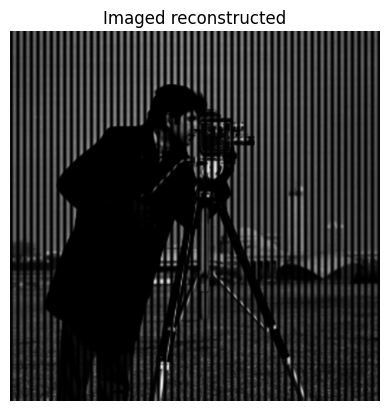

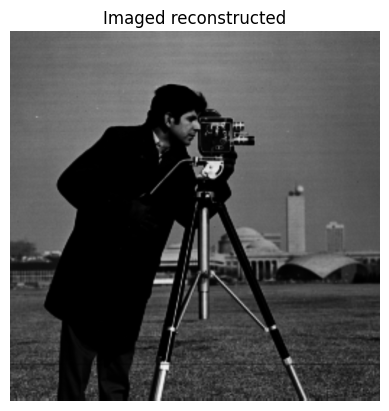

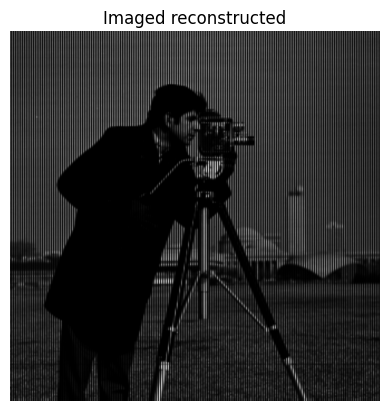

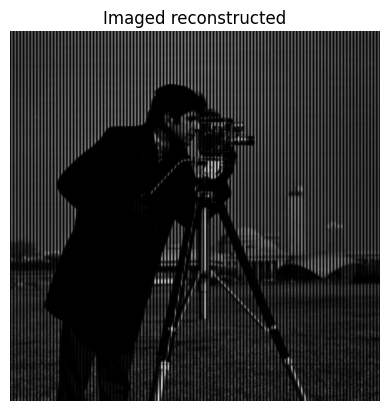

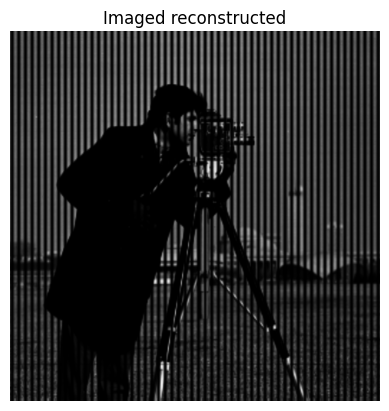

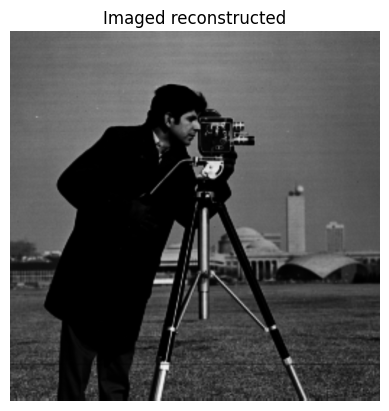

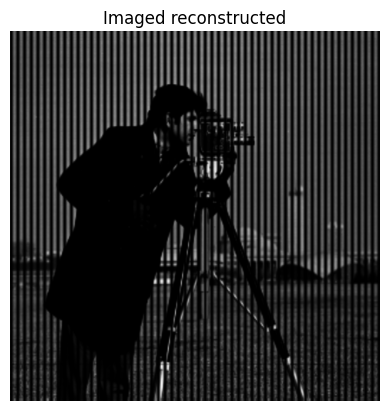

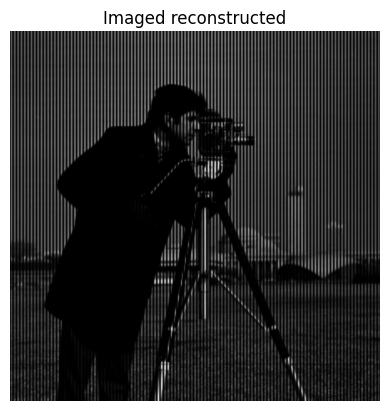

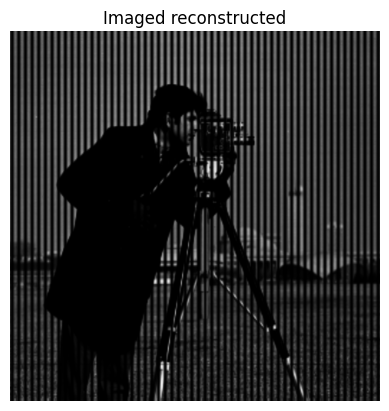

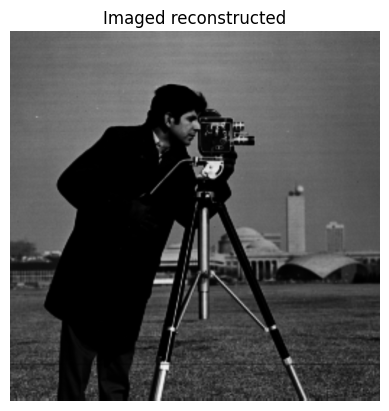

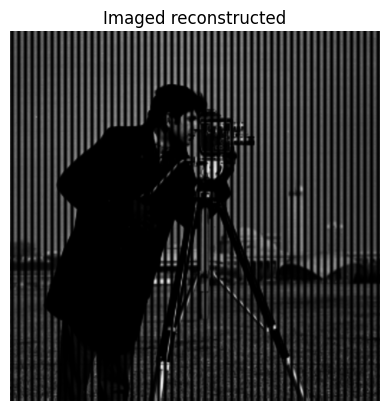

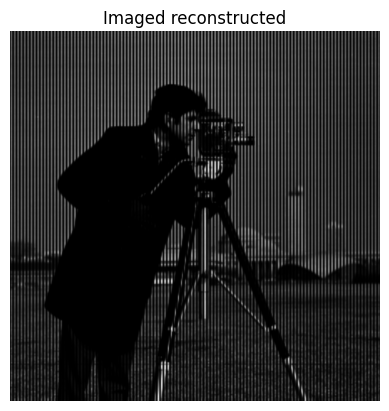

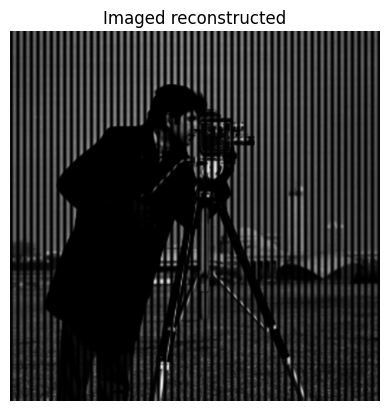

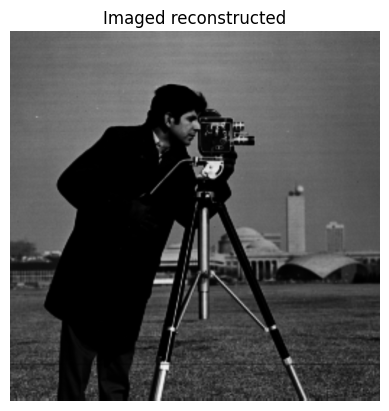

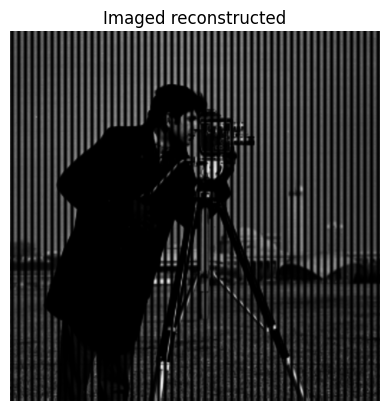

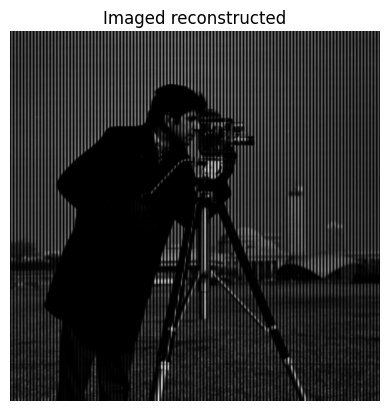

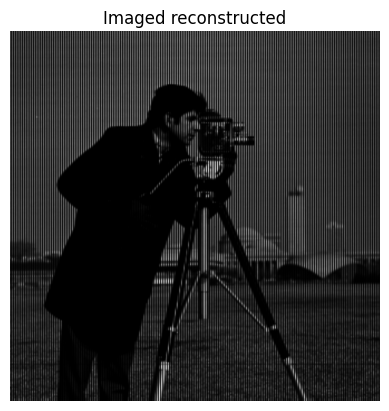

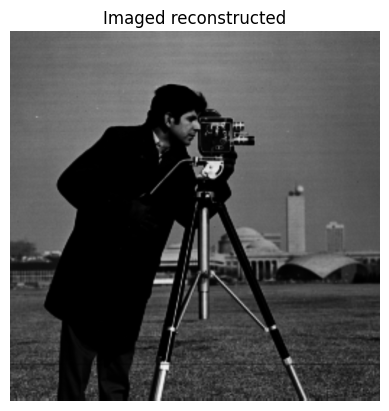

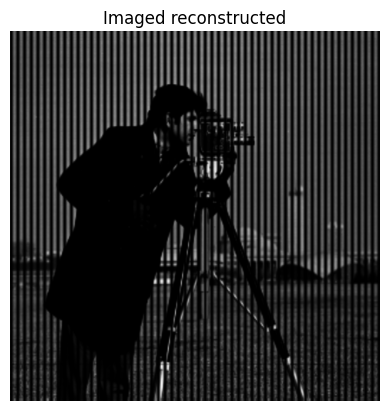

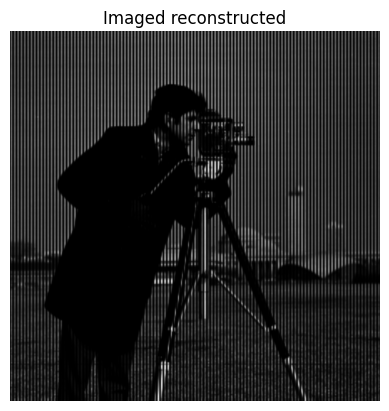

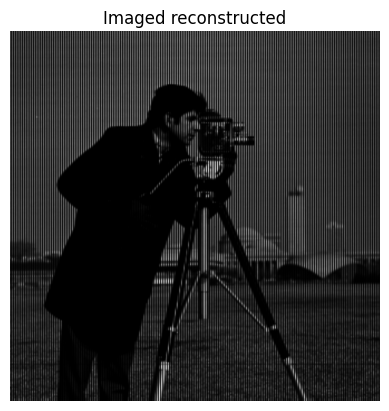

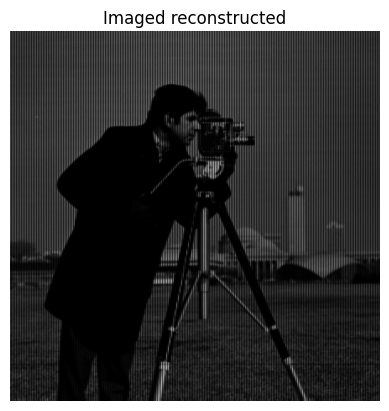

In [6]:
num_frames = imaged_images.shape[0]

for i in range(num_frames):
    plt.figure()
    plt.imshow(imaged_images[i], cmap='gray')
    plt.title('Imaged reconstructed')
    plt.axis('off')
plt.show()